In [4]:
import os

import pandas
import wfdb
from wfdb import processing
import numpy as np
from scipy import interpolate

In [35]:
class HeartbeatSlicer:
    def __init__(self, record_path, sampfrom, sampto, num_heartbeats=3):
        self.record = wfdb.rdrecord(record_name=record_path, sampfrom=sampfrom, sampto=sampto)
        self.annotations = wfdb.rdann(record_name=record_path, extension='atr', sampfrom=sampfrom, sampto=sampto, shift_samps=True)
        self.ann_symbols = self.annotations.symbol
        self.ecg_data = self.record.p_signal[:, 0]
        self.sampling_rate = self.record.fs
        self.peak_indices = self.detect_peaks()
        self.num_heartbeats = num_heartbeats
        self.label_dict = {
         # Normal Beats (Non-Arrhythmia):
            #     N: Normal beat
            #     /: Paced beat (This is considered normal when a patient has a pacemaker)
        'N': 0, '/': 0,

        # Supraventricular Arrhythmias:
            #     A: Atrial premature beat
            #     a: Aberrated atrial premature beat
            #     S: Supraventricular premature or ectopic beat (atrial or nodal)
            #     e: Atrial escape beat
            #     n: Supraventricular escape beat (atrial or nodal)
        'A': 1, 'a': 1, 'S': 1, 'e': 1, 'n': 1,

        # Ventricular Arrhythmias:
            #     V: Premature ventricular contraction
            #     r: R-on-T premature ventricular contraction
            #     E: Ventricular escape beat
            #     F: Fusion of ventricular and normal beat
        'V': 2, 'r': 2, 'E': 2, 'F': 2,

        # Conduction Problems (Bundle Branch Blocks):
            #     L: Left bundle branch block beat
            #     R: Right bundle branch block beat
            #     B: Bundle branch block beat (unspecified)
        'L': 3, 'R': 3, 'B': 3,

        # Junctional Rhythms:
            #     J: Nodal (junctional) premature beat
            #     j: Nodal (junctional) escape beat
        'J': 4, 'j': 4,
        # Paced Rhythms:
            #     f: Fusion of paced and normal beat
        'f': 5,
        # Unclassifiable/Other Beats:
            #     Q: Unclassifiable beat
            #     ?: Beat not classified during learning
        'Q': 6, '?': 6}


    def detect_peaks(self):
        """
        Detects peaks in the ECG data.

        Returns: numpy array with the indices of peaks.
        """

        # peak_indices = processing.gqrs_detect(sig=self.ecg_data, fs=self.sampling_rate)

        #Or use annoted peaks???
        peak_indices = self.annotations.sample


        return np.array(peak_indices, dtype=object)


    def interpolate_sequence(self):
        x = np.linspace(0, len(self.peak_indices) - 1, len(self.peak_indices) - 1)
        f = interpolate.interp1d(np.arange(len(self.peak_indices)), self.peak_indices, kind='cubic')
        print(f(x))

        return f(x)

    def slice_heartbeats(self):
        """
        Slice the ECG data into sequences of a fixed number of consecutive heartbeats.

        num_heartbeats : The number of consecutive heartbeats to include in each sequence.

        Returns: 2D numpy array, each row is a sequence of heartbeats.
        """
        heartbeats = []

        # FIXME: check distance between peaks???
        for i in range(self.num_heartbeats, len(self.peak_indices)-self.num_heartbeats):
            start = self.peak_indices[i] - (self.peak_indices[i] - self.peak_indices[i-self.num_heartbeats])//2
            end = self.peak_indices[i] +  (self.peak_indices[i+self.num_heartbeats] - self.peak_indices[i])//2
            sequence = self.ecg_data[start:end]

            heartbeats.append(sequence)

        return np.array(heartbeats, dtype=object)


    def annotate_heartbeats(self):
        heartbeats = self.slice_heartbeats()
        # FIXME: add more labels
        anns = list(map(lambda x: self.label_dict.get(x, x), self.ann_symbols[self.num_heartbeats:-self.num_heartbeats]))

        return np.column_stack((heartbeats, anns))






In [6]:
record = wfdb.rdrecord(record_name='data_processed/mitdb/100_processed', sampfrom=0, sampto=3000)
annotation = wfdb.rdann('data_processed/mitdb/100_processed', 'atr', sampfrom=0, sampto=3000, shift_samps=True, summarize_labels=True)
sliced = HeartbeatSlicer(record_path='data_processed/mitdb/100_processed', sampfrom=0, sampto=3000, num_heartbeats=3)

/home/pap1rana/.local/lib/python3.10/site-packages/wfdb/io/annotation.py:1355: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  contained_labels = label_map.loc[index_vals, :]


In [7]:
print(sliced.peak_indices)
# sliced.interpolate_sequence()

[10 42 205 367 525 683 841 1005 1135 1334 1503 1665 1823 1977 2145 2316
 2481 2646 2811 2970]


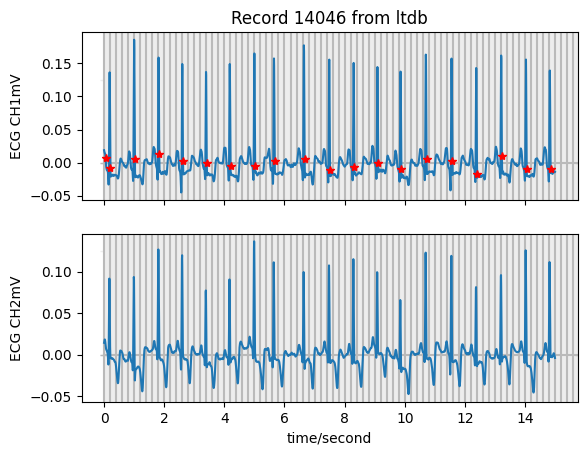

In [8]:
wfdb.plot_wfdb(record=record, annotation=annotation, title='Record 14046 from ltdb', ecg_grids='all')

In [9]:
sliced.annotate_heartbeats()

array([[array([-0.01220739, -0.01600969, -0.02121284, -0.02621587, -0.02761672,
               -0.02021224,  0.00060036,  0.03722254,  0.08545174,  0.13508179,
                0.1721042 ,  0.18551232,  0.17130372,  0.13448142,  0.08625222,
                0.03982411,  0.00500303, -0.01460885, -0.02181321, -0.02201333,
               -0.02041236, -0.01941175, -0.01921163, -0.01961187, -0.02021224,
               -0.02061248, -0.0208126 , -0.02061248, -0.02041236, -0.02041236,
               -0.02041236, -0.02061248, -0.02101272, -0.02141296, -0.02181321,
               -0.02221345, -0.02241357, -0.02241357, -0.02221345, -0.02161309,
               -0.02101272, -0.02041236, -0.02001212, -0.01961187, -0.01921163,
               -0.01901151, -0.01901151, -0.01881139, -0.01901151, -0.01921163,
               -0.01961187, -0.02021224, -0.0208126 , -0.02141296, -0.02221345,
               -0.02301393, -0.02381442, -0.0246149 , -0.02561551, -0.02661612,
               -0.02761672, -0.02861733,

In [10]:
import pandas
data = pandas.DataFrame(sliced.annotate_heartbeats())

In [37]:
testMitdb = HeartbeatSlicer("data_processed/mitdb/100_processed", sampfrom=0, sampto=200000).annotate_heartbeats()
testNsrb = HeartbeatSlicer("data_processed/nsrdb/16265_processed", sampfrom=0, sampto=200000).annotate_heartbeats()
testSvdb = HeartbeatSlicer("data_processed/svdb/800_processed", sampfrom=0, sampto=200000).annotate_heartbeats()

In [12]:
from matplotlib import pyplot as plt

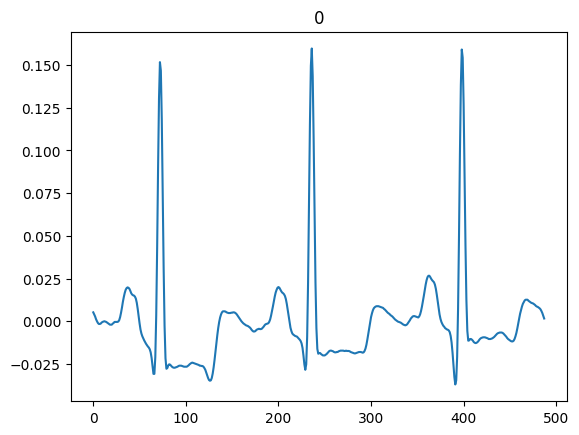

In [13]:
plt.plot(testMitdb[233][0])
plt.title(testMitdb[35][1])
plt.show()

# plt.plot(testSvdb[1001][0])
# plt.title(testSvdb[35][1])
# plt.show()
#
# plt.plot(testNsrb[727][0])
# plt.title(testNsrb[35][1])
# plt.show()

In [14]:
import os

folder_path = "data_processed/mitdb"
record_names_path = "data_original/mitdb/RECORDS"

with open(record_names_path, 'r') as record_names_file:
    record_names = record_names_file.readlines()

record_names = [record_name[:-1] for record_name in record_names]

In [15]:
dataMitDB = []

for record_name in record_names:
    sliced = HeartbeatSlicer(folder_path + '/' + record_name + '_processed', sampfrom=0, sampto=10000)
    dataMitDB.append(sliced.annotate_heartbeats())

In [16]:
#[patient][heartbeat]
dataMitDB[2][3][0].shape

(497,)

array([-0.00722406, -0.00742473, -0.00772573, -0.00802673, -0.00832774,
       -0.0085284 , -0.0085284 , -0.0085284 , -0.00862874, -0.00892974,
       -0.00953174, -0.01033442, -0.01123743, -0.01193976, -0.0126421 ,
       -0.01304344, -0.01344478, -0.01374578, -0.01414712, -0.01444812,
       -0.01484946, -0.01535113, -0.01565213, -0.01595313, -0.0161538 ,
       -0.01625413, -0.0161538 , -0.0161538 , -0.01605347, -0.01605347,
       -0.01595313, -0.01595313, -0.01595313, -0.01595313, -0.01605347,
       -0.0161538 , -0.0161538 , -0.0161538 , -0.0161538 , -0.01605347,
       -0.01605347, -0.01605347, -0.0161538 , -0.01625413, -0.0164548 ,
       -0.01665547, -0.01665547, -0.0164548 , -0.01595313, -0.01525079,
       -0.01454845, -0.01394645, -0.01354511, -0.01344478, -0.01354511,
       -0.01374578, -0.01374578, -0.01354511, -0.01294311, -0.0120401 ,
       -0.01053509, -0.00812707, -0.00280936,  0.00832774,  0.02638788,
        0.04826073,  0.06923057,  0.08458169,  0.09140442,  0.08

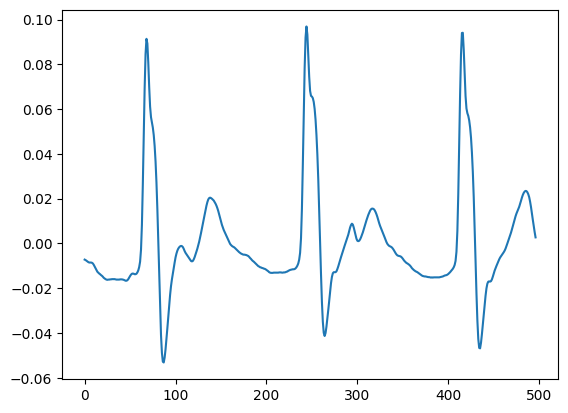

In [17]:
plt.plot(dataMitDB[2][2][0])
dataMitDB[2][2][0]

In [18]:
import gudhi
import gudhi.representations.vector_methods as grvm

In [19]:
def make_betti_curve(heartbeat):
    rips_complex = gudhi.RipsComplex(points=heartbeat.reshape(-1, 1))
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistence = simplex_tree.persistence()

    #plots
    # gudhi.plot_persistence_diagram(persistence)
    # barcode = gudhi.plot_persistence_barcode(persistence)

    #betti curve
    betti_curve_maker = grvm.BettiCurve(sample_range=[0.0, 1.0], resolution=100)
    #reshape
    # persistence = np.column_stack([np.array(dim_birth_death) for dim_birth_death in persistence])
    betti_curve = betti_curve_maker(simplex_tree.persistence_intervals_in_dimension(1))


    plt.plot(betti_curve)
    plt.xlabel("Time")
    plt.ylabel("Betti number")
    plt.show()

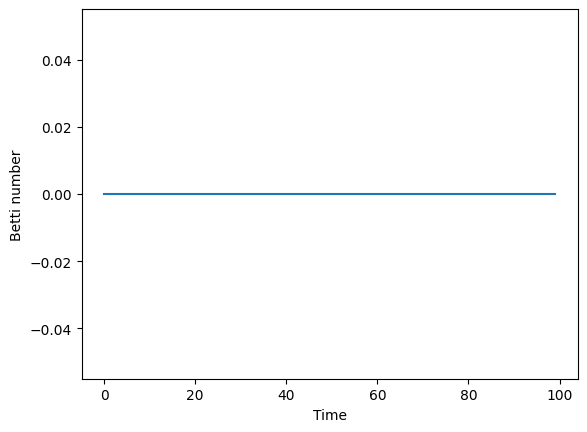

In [20]:
make_betti_curve(dataMitDB[2][2][0])

In [24]:
testMitdb

array([[array([-0.01220739, -0.01600969, -0.02121284, -0.02621587, -0.02761672,
               -0.02021224,  0.00060036,  0.03722254,  0.08545174,  0.13508179,
                0.1721042 ,  0.18551232,  0.17130372,  0.13448142,  0.08625222,
                0.03982411,  0.00500303, -0.01460885, -0.02181321, -0.02201333,
               -0.02041236, -0.01941175, -0.01921163, -0.01961187, -0.02021224,
               -0.02061248, -0.0208126 , -0.02061248, -0.02041236, -0.02041236,
               -0.02041236, -0.02061248, -0.02101272, -0.02141296, -0.02181321,
               -0.02221345, -0.02241357, -0.02241357, -0.02221345, -0.02161309,
               -0.02101272, -0.02041236, -0.02001212, -0.01961187, -0.01921163,
               -0.01901151, -0.01901151, -0.01881139, -0.01901151, -0.01921163,
               -0.01961187, -0.02021224, -0.0208126 , -0.02141296, -0.02221345,
               -0.02301393, -0.02381442, -0.0246149 , -0.02561551, -0.02661612,
               -0.02761672, -0.02861733,

In [41]:
np.unique(testMitdb[:, 1], return_counts=True)

(array([0, 1], dtype=object), array([1246,   14]))

In [39]:
np.unique(testSvdb[:, 1], return_counts=True)

(array(['0', '1', '2', '|', '~'], dtype=object),
 array([1101,   15,    6,    6,   12]))

In [40]:
np.unique(testNsrb[:, 1], return_counts=True)

(array(['0', '|', '~'], dtype=object), array([1594,   13,   16]))